In [1]:
import os
# Deshabilita la GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

# Suprime los logs de TensorFlow relacionados con errores e información
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  

# Suprime las advertencias para una salida más limpia
import warnings
warnings.filterwarnings('ignore')

# Importa TensorFlow y Keras
import tensorflow as tf
import keras

# Imprime las versiones de TensorFlow y Keras instaladas en el entorno
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

E0000 00:00:1733336657.101012   16433 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733336657.144691   16433 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Keras version: 3.6.0


In [2]:
# Importación de módulos estándar
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importación de módulos de Keras para construcción de modelos de redes neuronales
from keras.models import Sequential, Model
from keras.layers import Dense, Layer, Flatten, Input,  Lambda
from keras import regularizers
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy, MeanSquaredError
from keras import metrics
import tensorflow.keras.backend as K


# Importación de módulos de scikit-learn para preprocesamiento y evaluación de modelos
from sklearn.metrics import (classification_report, confusion_matrix,mean_squared_error, recall_score, precision_score, 
                             accuracy_score, f1_score, roc_auc_score)
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model



# Importación del módulo time para medir tiempos de ejecución
from time import time

# Configuración de semillas aleatorias para reproducibilidad
np.random.seed(7)
seed = 15
rng = np.random.RandomState(313)

# Configuración para visualizar gráficos en línea en Jupyter Notebook
%matplotlib inline


In [3]:
X_train_ae = pd.read_csv(r"../Datos/BinarioTrainBalanced.csv")
X_test_ae  = pd.read_csv(r"../Datos/BinarioTest1Balanced.csv")

In [4]:
print("\n\t\tDatos de entrenamiento")
nr_clases = X_train_ae['CLASS_LABEL'].value_counts(sort=True)
print("\nCantidad ",nr_clases,"\nPorcentajes", nr_clases*100/X_train_ae.shape[0])
Y_train_ae = X_train_ae['CLASS_LABEL']
X_train_ae = X_train_ae.drop(['CLASS_LABEL'], axis=1)
print(X_train_ae.shape, Y_train_ae.shape)

print("\n\t\tDatos de prueba AE")
nr_clases = X_test_ae['CLASS_LABEL'].value_counts(sort=True)
print("\nCantidad ",nr_clases,"\nPorcentajes", nr_clases*100/X_test_ae.shape[0])
Y_test_ae = X_test_ae['CLASS_LABEL']
X_test_ae = X_test_ae.drop(['CLASS_LABEL'], axis=1)
print(X_test_ae.shape, Y_test_ae.shape)


		Datos de entrenamiento

Cantidad  CLASS_LABEL
0    6212
1    6196
Name: count, dtype: int64 
Porcentajes CLASS_LABEL
0    50.064475
1    49.935525
Name: count, dtype: float64
(12408, 606) (12408,)

		Datos de prueba AE

Cantidad  CLASS_LABEL
0    777
1    774
Name: count, dtype: int64 
Porcentajes CLASS_LABEL
0    50.096712
1    49.903288
Name: count, dtype: float64
(1551, 606) (1551,)


## Implementar Autoencoder Variacional con Pérdida Personalizada  

En esta sección, se crea un **Autoencoder Variacional (VAE)** con una arquitectura personalizada para el `encoder` y `decoder`, incluyendo la implementación de una capa de pérdida combinada que calcula la **pérdida de reconstrucción** y la **divergencia KL (Kullback-Leibler)**. 

### Pasos del Código

#### 1. **Definición del `encoder`**
- **Entrada**:
  - Una capa de entrada `InputLayer` que recibe un vector de dimensión igual al número de características (`dim_entrada`).
- **Capas Ocultas**:
  - Dos capas densas (`Dense`) con activación `relu`:
    - Primera capa: `encoder_units1` (300 neuronas).
    - Segunda capa: `encoder_units2` (200 neuronas).
- **Variables del Espacio Latente**:
  - Media (`z_mean`) y log-varianza (`z_log_var`) de la distribución latente, ambas representadas como capas densas con `latent_dim` (90 dimensiones).
- **Reparametrización**:
  - Una capa `Lambda` implementa la reparametrización mediante la fórmula:
    `z = mu + sigma * epsilon`
    - `mu`: `z_mean`.
    - `sigma`: `exp(0.5 * z_log_var)`.
    - `epsilon`: Ruido gaussiano generado mediante `K.random_normal`.

#### 2. **Definición del `decoder`**
- **Entrada**:
  - Espacio latente (`z`), generado por el `encoder`.
- **Capas Ocultas**:
  - Dos capas densas (`Dense`) simétricas al `encoder`:
    - Primera capa: 200 neuronas (`encoder_units2`).
    - Segunda capa: 300 neuronas (`encoder_units1`).
- **Salida**:
  - Una capa densa con activación `linear` para reconstruir los datos originales.

#### 3. **Capa Personalizada de Pérdida**
- **Clase `VAE_LossLayer`**:
  - Calcula la pérdida total combinando:
    - **Pérdida de Reconstrucción**:
      `reconstruction_loss = MSE(inputs, outputs) * dim_entrada`
    - **Pérdida KL**:
      `kl_loss = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)`
  - Añade la pérdida total al modelo mediante `add_loss`.

#### 4. **Construcción del Modelo Completo**
- **Entradas**:
  - La capa de entrada original (`input_layer`).
- **Salidas**:
  - La salida reconstruida del `decoder`, pasada por la capa de pérdida (`VAE_LossLayer`).
- **Modelo**:
  - Un modelo funcional de Keras que conecta `encoder`, `decoder` y la capa de pérdida.

#### 5. **Compilación del Modelo**
- **Optimizador**:
  - Adam con una tasa de aprendizaje definida en `optimal_hyperparameters`.
- **Función de Pérdida**:
  - Gestionada automáticamente por la capa `VAE_LossLayer`.

#### 6. **Entrenamiento del Modelo**
- **Configuración**:
  - Entrenamiento del VAE durante 100 épocas con `EarlyStopping` para detener el entrenamiento si no hay mejora en la pérdida durante 10 épocas consecutivas.
- **Datos de Entrada**:
  - Conjunto de datos original para entrenamiento y validación.
- **Resultados Esperados**:
  - Reducción en la pérdida total, incluyendo la reconstrucción y la divergencia KL.

---

### Resultados Esperados
- **Representación Latente**:
  - Un espacio latente significativo que capture las características esenciales de los datos.
- **Reconstrucción Precisa**:
  - Reducción del error cuadrático medio en los datos reconstruidos.
- **Generalización**:
  - La regularización mediante la pérdida KL promueve un modelo que puede generalizar mejor a nuevos datos.


In [5]:
# Capa personalizada para la pérdida de reconstrucción + KL divergence
class VAE_LossLayer(Layer):
    def __init__(self, input_dim, **kwargs):
        super(VAE_LossLayer, self).__init__(**kwargs)
        self.input_dim = input_dim

    def call(self, inputs):
        z_mean, z_log_var, inputs, outputs = inputs
        # Pérdida de reconstrucción
        reconstruction_loss = MeanSquaredError()(inputs, outputs)
        reconstruction_loss *= self.input_dim  # Escalar por dimensiones de entrada
        
        # Pérdida KL Divergence
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        
        # Agregar las pérdidas al modelo
        total_loss = K.mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)
        return outputs

In [6]:
from tensorflow.keras import backend as K

# Definir R² como métrica personalizada
def r2_score(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))  # Suma de los residuos al cuadrado
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Suma total de cuadrados
    return 1 - ss_res / (ss_tot + K.epsilon())  # Epsilon para evitar divisiones por cero

In [7]:
# Muestreo (Sampling Layer)
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [8]:
# Hiperparámetros (proporcionados)
optimal_hyperparameters = {
    'encoder_units1': 300,
    'encoder_units2': 200,
    'encoder_units3': 100,
    'latent_dim': 20,
    'learning_rate': 0.001
}

In [9]:
dim_entrada = 606  # Número de características de entrada

# Definir las capas del encoder
input_layer = Input(shape=(dim_entrada,), name="input_layer")
x = Dense(optimal_hyperparameters['encoder_units1'], activation='relu', name="encoder_dense1")(input_layer)
x = Dense(optimal_hyperparameters['encoder_units2'], activation='relu', name="encoder_dense2")(x)
x = Dense(optimal_hyperparameters['encoder_units3'], activation='relu', name="encoder_dense3")(x)

# Variables del espacio latente
z_mean = Dense(optimal_hyperparameters['latent_dim'], name='z_mean')(x)
z_log_var = Dense(optimal_hyperparameters['latent_dim'], name='z_log_var')(x)

# Reparametrización (sampling) para obtener z
z = Lambda(lambda x: x[0] + K.exp(0.5 * x[1]) * K.random_normal(shape=(K.shape(x[0])[0], optimal_hyperparameters['latent_dim'])),
           name='z')([z_mean, z_log_var])

# Definir las capas del decoder
decoder_x = Dense(optimal_hyperparameters['encoder_units3'], activation='relu', name="decoder_dense3")(z)
decoder_x = Dense(optimal_hyperparameters['encoder_units2'], activation='relu', name="decoder_dense1")(decoder_x)
decoder_x = Dense(optimal_hyperparameters['encoder_units1'], activation='relu', name="decoder_dense2")(decoder_x)
outputs = Dense(dim_entrada, activation='linear', name="output_layer")(decoder_x)

# Aplicar la capa personalizada de pérdidas
vae_outputs = VAE_LossLayer(input_dim=dim_entrada)([z_mean, z_log_var, input_layer, outputs])

# Construir el modelo VAE completo
vae = Model(inputs=input_layer, outputs=vae_outputs, name='vae')

In [10]:
from tensorflow.keras.metrics import MeanAbsoluteError

# Compilar el modelo con métricas adicionales
vae.compile(
    optimizer=Adam(learning_rate=optimal_hyperparameters['learning_rate']),
    loss=None,  # La pérdida ya está gestionada por la capa personalizada
    metrics=[MeanSquaredError(name="mse"), 
             MeanAbsoluteError(name="mae"), 
             r2_score]  # Añade r2_score como métrica
)

# Resumen del modelo
vae.summary()


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 606)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense1      │ (None, 300)       │    182,100 │ input_layer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense2      │ (None, 200)       │     60,200 │ encoder_dense1[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense3      │ (None, 100)       │     20,100 │ encoder_dense2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 20)        │      2,020 │ encoder_dense3[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 20)        │      2,020 │ encoder_dense3[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 20)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense3      │ (None, 100)       │      2,100 │ z[0][0]           │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense1      │ (None, 200)       │     20,200 │ decoder_dense3[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense2      │ (None, 300)       │     60,300 │ decoder_dense1[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 606)       │    182,406 │ decoder_dense2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae__loss_layer     │ (None, 606)       │          0 │ z_mean[0][0],     │
│ (VAE_LossLayer)     │                   │            │ z_log_var[0][0],  │
│                     │                   │            │ input_layer[0][0… │
│                     │                   │            │ output_layer[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 531,446 (2.03 MB)

 Trainable params: 531,446 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

| Tipo               | Forma de Salida   | Parámetros |
|--------------------|-------------------|------------|
| InputLayer         | (None, 606)       | 0          |
| Dense (encoder_dense1) | (None, 300)       | 182,100    |
| Dense (encoder_dense2) | (None, 200)       | 60,200     |
| Dense (encoder_dense3) | (None, 100)       | 20,100     |
| Dense (z_mean)         | (None, 20)        | 2,020      |
| Dense (z_log_var)      | (None, 20)        | 2,020      |
| Lambda (z)            | (None, 20)        | 0          |
| Dense (decoder_dense3) | (None, 100)       | 2,100      |
| Dense (decoder_dense1) | (None, 200)       | 20,200     |
| Dense (decoder_dense2) | (None, 300)       | 60,300     |
| Dense (output_layer)   | (None, 606)       | 182,406    |
| VAE_LossLayer         | (None, 606)       | 0          |


In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Configurar EarlyStopping
early_stopping = EarlyStopping(
    monitor='loss',  # Monitorea la pérdida en los datos de entrenamiento
    patience=10,     # Detiene el entrenamiento si no hay mejora en 10 épocas consecutivas
    restore_best_weights=True  # Restaura los pesos del mejor modelo
)

history = vae.fit(
    X_train_ae, X_train_ae,
    validation_split=0.2,  # 20% de los datos como conjunto de validación
    epochs=100,
    batch_size=128,
    callbacks=[early_stopping],  # EarlyStopping configurado
    verbose=1
)



Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 49.7017 - mae: 0.1632 - mse: 0.0802 - r2_score: 0.5243 - val_loss: 5.5151 - val_mae: 0.0619 - val_mse: 0.0090 - val_r2_score: 0.9464
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0969 - mae: 0.0589 - mse: 0.0083 - r2_score: 0.9505 - val_loss: 3.7271 - val_mae: 0.0500 - val_mse: 0.0061 - val_r2_score: 0.9636
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5674 - mae: 0.0486 - mse: 0.0058 - r2_score: 0.9653 - val_loss: 2.8745 - val_mae: 0.0433 - val_mse: 0.0047 - val_r2_score: 0.9719
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8228 - mae: 0.0425 - mse: 0.0046 - r2_score: 0.9725 - val_loss: 2.5534 - val_mae: 0.0402 - val_mse: 0.0042 - val_r2_score: 0.9749
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5451 - mae: 0.0400 - mse: 0.0042 - r2_score: 0.9751 - val_loss: 2.4510 - val_mae: 0.0390 - val_mse: 0.0041 - val_r2_score: 0.9759
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5m

In [12]:
# Generar las reconstrucciones para los datos de prueba
reconstrucciones = vae.predict(X_test_ae)

# Verificar las dimensiones
print(f"Dimensiones de las reconstrucciones: {reconstrucciones.shape}")


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Dimensiones de las reconstrucciones: (1551, 606)


In [13]:
# Definir las métricas configuradas en el modelo
metricas = ['Loss', 'Mean Squared Error', 'Mean Absolute Error', 'R2 Score']

# Evaluar el VAE en el conjunto de entrenamiento
train_metrics = vae.evaluate(X_train_ae, X_train_ae, verbose=0)

print("\nMétricas del VAE en el Conjunto de Entrenamiento:")
print("-" * 50)
for nombre, valor in zip(metricas, train_metrics):
    print(f"{nombre}: {valor:.6f}")

# Obtener las métricas de validación desde el histórico de entrenamiento
print("\nMétricas del VAE en Validación (Última Época):")
print("-" * 50)
if 'val_loss' in history.history:
    val_loss = history.history['val_loss'][-1]
    val_mse = history.history['val_mse'][-1]
    val_mae = history.history['val_mae'][-1]
    val_r2 = history.history['val_r2_score'][-1]
    
    val_metrics = [val_loss, val_mse, val_mae, val_r2]
    for nombre, valor in zip(metricas, val_metrics):
        print(f"{nombre}: {valor:.6f}")
else:
    print("No se configuró un conjunto de validación durante el entrenamiento.")

# Evaluar el VAE en el conjunto de prueba
test_metrics = vae.evaluate(X_test_ae, X_test_ae, verbose=0)

print("\nMétricas del VAE en el Conjunto de Prueba:")
print("-" * 50)
for nombre, valor in zip(metricas, test_metrics):
    print(f"{nombre}: {valor:.6f}")



Métricas del VAE en el Conjunto de Entrenamiento:
--------------------------------------------------
Loss: 2.109332
Mean Squared Error: 0.002867
Mean Absolute Error: 0.032487
R2 Score: 0.982936

Métricas del VAE en Validación (Última Época):
--------------------------------------------------
Loss: 2.055047
Mean Squared Error: 0.002785
Mean Absolute Error: 0.032020
R2 Score: 0.983404

Métricas del VAE en el Conjunto de Prueba:
--------------------------------------------------
Loss: 2.120601
Mean Squared Error: 0.002875
Mean Absolute Error: 0.032613
R2 Score: 0.982920


### **Resumen de Desempeño**
| Métrica               | Entrenamiento      | Validación        | Prueba            |
|-----------------------|--------------------|-------------------|-------------------|
| **`MSE`**             | 0.000206          | 0.000206          | 0.000208          |
| **`MAE`**             | 0.009519          | 0.009521          | 0.009567          |
| **`R2 Score`**        | 0.998776          | 0.998774          | 0.998768          |


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Función para visualizar la reconstrucción de una señal específica
def visualizar_reconstruccion(autoencoder, datos_originales, indice):
    """
    Visualiza una señal original y su reconstrucción realizada por el autoencoder.
    
    Parámetros:
    - autoencoder: El modelo autoencoder entrenado.
    - datos_originales: Conjunto de datos original (DataFrame o array).
    - indice: Índice de la señal a visualizar (fila del conjunto de datos).
    """
    # Asegurarse de que los datos son un array NumPy
    if isinstance(datos_originales, pd.DataFrame):
        datos_originales = datos_originales.values  # Convertir DataFrame a array si es necesario
    
    # Validar el índice
    if indice < 0 or indice >= datos_originales.shape[0]:
        raise ValueError(f"Índice fuera de rango. Debe estar entre 0 y {datos_originales.shape[0] - 1}.")
    
    # Obtener la señal original (fila)
    señal_original = datos_originales[indice]
    
    # Reconstruir la señal usando el autoencoder
    señal_reconstruida = autoencoder.predict(señal_original.reshape(1, -1), verbose=0)[0]
    
    # Graficar la señal original y reconstruida
    plt.figure(figsize=(9, 4))
    plt.plot(señal_original, label='Señal Original', color='blue', alpha=0.7, linewidth=2)
    plt.plot(señal_reconstruida, label='Señal Reconstruida', color='red', linestyle='dashed', alpha=0.7, linewidth=2)
    plt.title(f"Reconstrucción de la Señal - Índice: {indice}", fontsize=14)
    plt.xlabel("Índice de Característica", fontsize=12)
    plt.ylabel("Valor", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


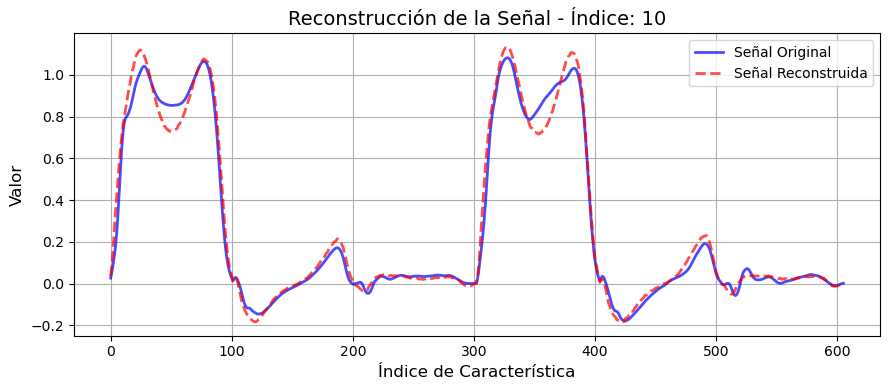

In [15]:
# Visualizar la reconstrucción de la señal en el índice 10
visualizar_reconstruccion(vae, X_test_ae, 10)

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Crear el encoder como modelo independiente
encoder = Model(inputs=vae.input, outputs=vae.get_layer('z').output)

# Generar el espacio latente utilizando el encoder
espacio_latente = encoder.predict(X_train_ae)

# Verificar las dimensiones del espacio latente
print(f"Dimensiones de X_train_ae: {X_train_ae.shape}")
print(f"Dimensiones del espacio latente: {espacio_latente.shape}")


388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
Dimensiones de X_train_ae: (12408, 606)
Dimensiones del espacio latente: (12408, 20)


In [17]:

# Guardar el encoder
encoder.save("../Modelos/Variational_Encoder_v2.keras")
print("Encoder guardado exitosamente.")

Encoder guardado exitosamente.


In [18]:

# Reducir el espacio latente a 2 dimensiones usando t-SNE
tsne = TSNE(n_components=2, random_state=42)
espacio_latente_2D = tsne.fit_transform(espacio_latente)

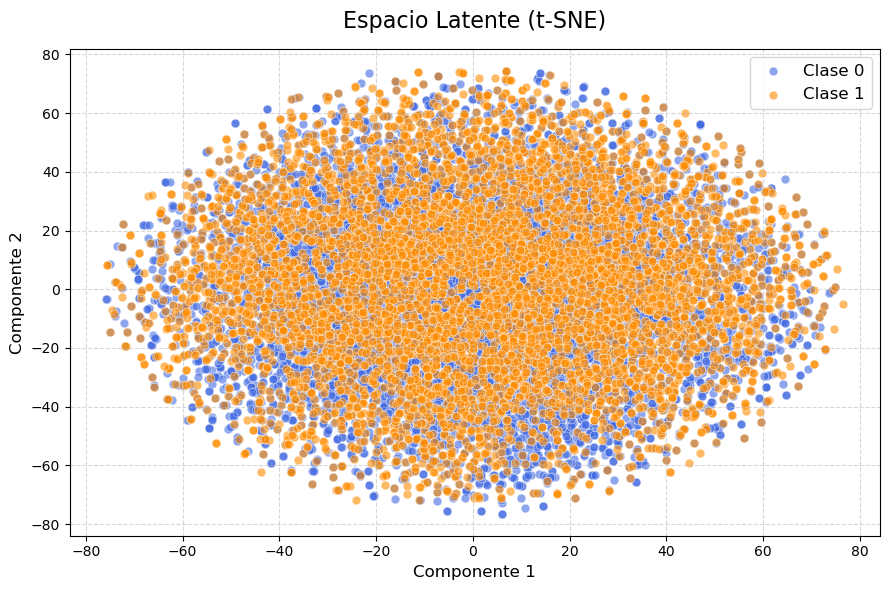

In [19]:

# Visualizar el espacio latente utilizando un scatter plot con mejoras
plt.figure(figsize=(9, 6))
colores = ['royalblue', 'darkorange']  # Colores para las clases

# Graficar los puntos para cada clase
for i, clase in enumerate([0, 1]):
    indices = Y_train_ae == clase
    plt.scatter(
        espacio_latente_2D[indices, 0], 
        espacio_latente_2D[indices, 1], 
        label=f'Clase {clase}',
        alpha=0.6,  # Transparencia para superposición
        c=colores[i],
        edgecolor='w',  # Bordes blancos para claridad
        linewidth=0.5,
        s=40  # Tamaño de los puntos
    )

# Configuración del gráfico
plt.title("Espacio Latente (t-SNE)", fontsize=16, pad=15)
plt.xlabel("Componente 1", fontsize=12)
plt.ylabel("Componente 2", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Agregar una cuadrícula suave
plt.tight_layout()
plt.show()


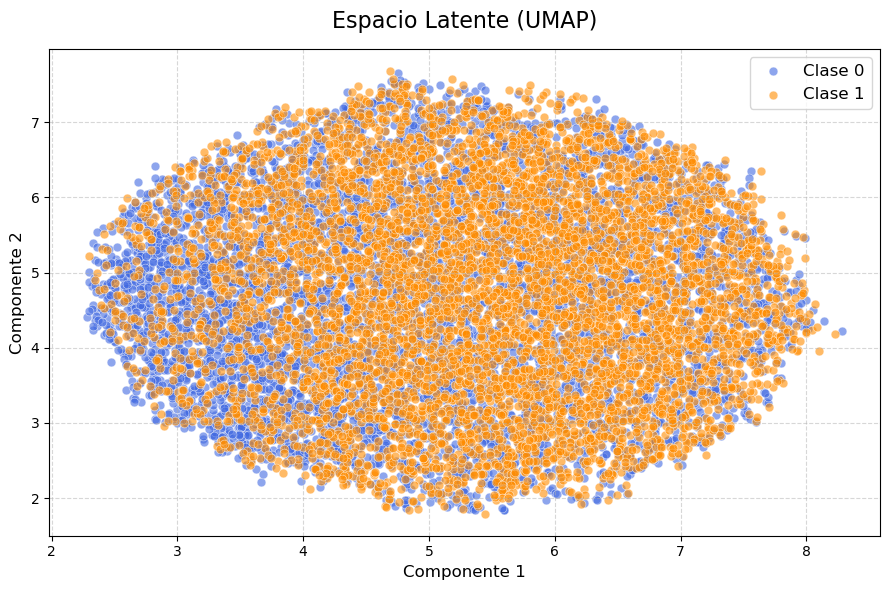

In [ ]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# Configurar UMAP
umap_reducer = umap.UMAP(
    n_components=2,      # Reducir a 2 dimensiones
    n_neighbors=15,      # Controla la cantidad de vecinos locales considerados
    min_dist=0.1,        # Controla cuán apretados están los puntos en la proyección
    random_state=42      # Reproducibilidad
)

# Reducir el espacio latente a 2 dimensiones
espacio_latente_2D_umap = umap_reducer.fit_transform(espacio_latente)

# Visualizar el espacio latente utilizando UMAP
plt.figure(figsize=(9, 6))
colores = ['royalblue', 'darkorange']  # Colores para las clases

# Graficar los puntos para cada clase
for i, clase in enumerate([0, 1]):
    indices = Y_train_ae == clase
    plt.scatter(
        espacio_latente_2D_umap[indices, 0], 
        espacio_latente_2D_umap[indices, 1], 
        label=f'Clase {clase}',
        alpha=0.6,  # Transparencia para superposición
        c=colores[i],
        edgecolor='w',  # Bordes blancos para claridad
        linewidth=0.5,
        s=40  # Tamaño de los puntos
    )

# Configuración del gráfico
plt.title("Espacio Latente (UMAP)", fontsize=16, pad=15)
plt.xlabel("Componente 1", fontsize=12)
plt.ylabel("Componente 2", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Agregar una cuadrícula suave
plt.tight_layout()
plt.show()
